In this notebook we calculate 
1. average player statistics over entire league matches 
2. variable player performance for each match
3. Encode player positions into player performance
4. Encode team formation to predict scoreline

In [1]:
from glob import glob
import pandas as pd
import numpy as np
import os
import json

In [9]:
# Player statistics files
teamspath = glob('../../../MusicRecMix/tracks/tracksharepoint/N*/*Football*/*2526_FINAL*/*')

In [10]:
# get team names
teamnames = [os.path.basename(teampath) for teampath in teamspath]

In [12]:
len(teamnames)

20

In [13]:
# for each team name, remove \xa0 with a space
teaminfo = {name: {'path': f'../../../MusicRecMix/tracks/tracksharepoint/National University of Singapore/Sandesh Sreepathy Upadhyaya - Football Dataset/2526_FINAL/{name}'} for name in teamnames}
# replace \xa0 with space in team names
teaminfo = {name.replace('\xa0', ' '): info for name, info in teaminfo.items()}

extract player statistics for each team

It seems non-PL matches data is mostly empty and hence unreliable, so we will only consider PL matches to get average player statistics

In [100]:
playerinfo = {}
for team, info in teaminfo.items():
    playerinfo[team] = {}
    playerpath= info['path']
    playernames = [os.path.basename(p) for p in glob(f"{playerpath}/*") if os.path.isdir(p)]
    print(team,playernames)
    for player in playernames:
        player_allfiles = glob(f"{playerpath}/{player}/*.json")
        if len(player_allfiles) == 0:
            continue
        playerinfo[team][player] = {}
        for pf in player_allfiles:
            if "all.json" in pf:
                continue
            fname = pf.split('/')[-1].replace('.json','')
            playerinfo[team][player][fname] = pf

        playerinfo[team][player]['team'] = team

        # if info.json exists, load it
        infofile = f"{playerpath}/{player}/info.json"
        if os.path.exists(infofile):
            with open(infofile, 'r') as f:
                infodict = json.load(f)
            for k, v in infodict.items():
                playerinfo[team][player][k] = v

Arsenal ['Andre Annous', 'Ben White', 'Bukayo Saka', 'Christian Nørgaard', 'Cristhian Mosquera', 'David Raya', 'Declan Rice', 'Eberechi Eze', 'Ethan Nwaneri', 'Gabriel Magalhães', 'Gabriel Martinelli', 'Jakub Kiwior', 'Jurriën Timber', 'Kai Havertz', 'Kepa Arrizabalaga', 'Leandro Trossard', 'Martin Ødegaard', 'Martín Zubimendi', 'Max Dowman', 'Mikel Merino', 'Myles Lewis-Skelly', 'Noni Madueke', 'Piero Hincapié', 'Riccardo Calafiori', 'Viktor Gyökeres', 'William Saliba']
Aston Villa ['Amadou Onana', 'Boubacar Kamara', 'Bradley Paul Burrowes', 'Donyell Malen', 'Emi Buendía', 'Emiliano Martínez', 'Evann Guessand', 'Ezri Konsa', 'Harvey Elliott', 'Ian Maatsen', 'Jadon Sancho', 'Jamaldeen Jimoh', 'James Wright', 'John McGinn', 'Lamare Bogarde', 'Lucas Digne', 'Marco Bizot', 'Matty Cash', 'Morgan Rogers', 'Ollie Watkins', 'Pau Torres', 'Ross Barkley', 'Sam Proctor', 'Samuel Iling-Junior', 'Travis Patterson', 'Triston Rowe', 'Tyrone Mings', 'Victor Lindelöf', 'Youri Tielemans']
Bournemouth [

In [101]:
# print first element of each json file for a player say haaland
feat_sets = set()
for k,v in playerinfo['Manchester City']['Erling Haaland'].items():
    if k in ['team','position','age','height','weight','name','Footed','info']:
        continue
    with open(v, 'r') as f:
        data = json.load(f)
    #print(k, type(data))
    print(k, data[5])
    for key in data[5].keys():
        feat_sets.add(key)


defense {'Date': '2025-09-27', 'Day': 'Sat', 'Comp': 'Premier League', 'Round': 'Matchweek 6', 'Venue': 'Home', 'Result': 'W 5–1', 'Squad': 'Manchester City', 'Opponent': 'Burnley', 'Start': 'Y', 'Pos': 'FW', 'Min': '90', 'Tkl': '0', 'TklW': '0', 'Def 3rd': '0', 'Mid 3rd': '0', 'Att 3rd': '0', 'Att': '0', 'Tkl%': '', 'Lost': '0', 'Blocks': '1', 'Sh': '0', 'Pass': '1', 'Int': '0', 'Tkl+Int': '0', 'Clr': '2', 'Err': '0', 'Match Report': 'Match Report'}
keeper {'Date': '2025-09-27', 'Day': 'Sat', 'Comp': 'Premier League', 'Round': 'Matchweek 6', 'Venue': 'Home', 'Result': 'W 5–1', 'Squad': 'Manchester City', 'Opponent': 'Burnley', 'Start': 'Y', 'Pos': 'FW', 'Min': '90', 'SoTA': '', 'GA': '', 'Saves': '', 'Save%': '', 'CS': '', 'PSxG': '', 'PKatt': '', 'PKA': '', 'PKsv': '', 'PKm': '', 'Cmp': '', 'Att': '', 'Cmp%': '', 'Att (GK)': '', 'Thr': '', 'Launch%': '', 'AvgLen': '', 'Opp': '', 'Stp': '', 'Stp%': '', '#OPA': '', 'AvgDist': '', 'Match Report': 'Match Report'}
keeper_adv {'Date': '202

In [16]:
# Inspired from Darian's position weight code
from collections import defaultdict

def safe_float(x):
    try:
        return float(x)
    except (ValueError, TypeError):
        return None

def process_player_summary(playername, plsummarypath):

    posset = set()

    if not os.path.exists(plsummarypath):
        return None

    with open(plsummarypath, "r", encoding="utf-8") as f:
        try:
            data = json.load(f)
        except Exception:
            return None

    pos_minutes = defaultdict(float)
    match_num = 0
    player_name = playername

    for item in data:
        min_val = safe_float(item.get("Min"))
        if min_val is None:
            continue
        match_num += 1

        pos_val = item.get("Pos", "")
        if pos_val and pos_val != "On matchday squad, but did not play":
            positions = [p for p in pos_val.replace(" ", "").split(",") if p]
            for p in positions:
                pos_minutes[p] += min_val
                posset.add(p) # assuming equal minutes if multiple positions

    total_min = sum(pos_minutes.values())
    pos_weights = {p: pos_minutes[p] / total_min if total_min > 0 else 0 for p in pos_minutes}

    return player_name, pos_weights

In [102]:
# for each player in playerinfo. process position weights and add to playerinfo

# read_playerinfo

# with open('playerinfo_final.json', 'r') as f:
#     playerinfo = json.load(f)

for team, players in playerinfo.items():
    for player, info in players.items():
        plsummarypath = info.get('summary')
        print(player, plsummarypath)
        if not plsummarypath:
            continue
        result = process_player_summary(player, plsummarypath)
        if result is None:
            continue
        player_name, pos_weights = result
        playerinfo[team][player]['position_weights'] = pos_weights

Andre Annous ../../../MusicRecMix/tracks/tracksharepoint/National University of Singapore/Sandesh Sreepathy Upadhyaya - Football Dataset/2526_FINAL/Arsenal/Andre Annous/summary.json
Ben White ../../../MusicRecMix/tracks/tracksharepoint/National University of Singapore/Sandesh Sreepathy Upadhyaya - Football Dataset/2526_FINAL/Arsenal/Ben White/summary.json
Bukayo Saka ../../../MusicRecMix/tracks/tracksharepoint/National University of Singapore/Sandesh Sreepathy Upadhyaya - Football Dataset/2526_FINAL/Arsenal/Bukayo Saka/summary.json
Christian Nørgaard ../../../MusicRecMix/tracks/tracksharepoint/National University of Singapore/Sandesh Sreepathy Upadhyaya - Football Dataset/2526_FINAL/Arsenal/Christian Nørgaard/summary.json
Cristhian Mosquera ../../../MusicRecMix/tracks/tracksharepoint/National University of Singapore/Sandesh Sreepathy Upadhyaya - Football Dataset/2526_FINAL/Arsenal/Cristhian Mosquera/summary.json
David Raya ../../../MusicRecMix/tracks/tracksharepoint/National University

In [18]:
playerinfo['Manchester City']['Bernardo Silva']

{'defense': '../../../MusicRecMix/tracks/tracksharepoint/National University of Singapore/Sandesh Sreepathy Upadhyaya - Football Dataset/2526_FINAL/Manchester\xa0City/Bernardo Silva/defense.json',
 'info': '../../../MusicRecMix/tracks/tracksharepoint/National University of Singapore/Sandesh Sreepathy Upadhyaya - Football Dataset/2526_FINAL/Manchester\xa0City/Bernardo Silva/info.json',
 'keeper': '../../../MusicRecMix/tracks/tracksharepoint/National University of Singapore/Sandesh Sreepathy Upadhyaya - Football Dataset/2526_FINAL/Manchester\xa0City/Bernardo Silva/keeper.json',
 'keeper_adv': '../../../MusicRecMix/tracks/tracksharepoint/National University of Singapore/Sandesh Sreepathy Upadhyaya - Football Dataset/2526_FINAL/Manchester\xa0City/Bernardo Silva/keeper_adv.json',
 'misc': '../../../MusicRecMix/tracks/tracksharepoint/National University of Singapore/Sandesh Sreepathy Upadhyaya - Football Dataset/2526_FINAL/Manchester\xa0City/Bernardo Silva/misc.json',
 'passing': '../../../M

In [19]:
def split_WB_posset(weights, posset):
    w_WB = weights.get('WB', 0)
    if w_WB == 0:
        return weights, posset  # 没有 WB，直接返回

    # 定义左右位置集合
    left_positions = ['LB','LM','LW']
    right_positions = ['RB','RM','RW']

    total_L = sum(weights.get(p,0) for p in left_positions)
    total_R = sum(weights.get(p,0) for p in right_positions)
    total = total_L + total_R

    if total == 0:
        ratio_L, ratio_R = 0.5, 0.5
    else:
        ratio_L = total_L / total
        ratio_R = total_R / total

    # 拆分 WB 权重
    w_LWB = w_WB * ratio_L
    w_RWB = w_WB * ratio_R

    # 更新 weights
    new_weights = weights.copy()
    new_weights.pop('WB')
    if w_LWB > 0:
        new_weights['LWB'] = w_LWB
    if w_RWB > 0:
        new_weights['RWB'] = w_RWB

    # 更新 posset
    new_posset = [p for p in posset if p != 'WB']
    if w_LWB > 0:
        new_posset.append('LWB')
    if w_RWB > 0:
        new_posset.append('RWB')

    return new_weights, new_posset

In [103]:
# for each player in each team, process position weights
for team, players in playerinfo.items():
    for player, info in players.items():
        pos_weights = info.get('position_weights', {})
        posset = list(pos_weights.keys())
        new_weights, new_posset = split_WB_posset(pos_weights, posset)
        print(new_weights, new_posset)
        playerinfo[team][player]['position_weights'] = new_weights
        playerinfo[team][player]['position_set'] = new_posset

{} []
{'RB': 1.0} ['RB']
{'RW': 0.7077922077922078, 'LW': 0.07305194805194805, 'LM': 0.07305194805194805, 'RM': 0.1461038961038961} ['RW', 'LW', 'LM', 'RM']
{'CM': 0.5, 'FW': 0.5} ['CM', 'FW']
{'RB': 0.11244979919678715, 'CB': 0.8875502008032129} ['RB', 'CB']
{'GK': 1.0} ['GK']
{'LM': 0.6094276094276094, 'DM': 0.20202020202020202, 'CM': 0.18855218855218855} ['LM', 'DM', 'CM']
{'AM': 0.2872200263504611, 'LW': 0.2490118577075099, 'RM': 0.24242424242424243, 'DM': 0.05928853754940711, 'CM': 0.05928853754940711, 'LM': 0.10276679841897234} ['AM', 'LW', 'RM', 'DM', 'CM', 'LM']
{'RM': 0.8076923076923077, 'DM': 0.04487179487179487, 'CM': 0.14743589743589744} ['RM', 'DM', 'CM']
{'CB': 1.0} ['CB']
{'LW': 0.6866359447004609, 'RW': 0.2073732718894009, 'RM': 0.05069124423963134, 'LM': 0.055299539170506916} ['LW', 'RW', 'RM', 'LM']
{} []
{'RB': 1.0} ['RB']
{'FW': 1.0} ['FW']
{} []
{'LW': 0.6875, 'AM': 0.15257352941176472, 'LB': 0.15992647058823528} ['LW', 'AM', 'LB']
{'RM': 0.9556650246305419, 'LM': 

In [24]:
playerinfo['Manchester City'].keys()

dict_keys(['Abdukodir Khusanov', 'Bernardo Silva', 'Divine Mukasa', 'Ederson', 'Erling Haaland', 'Gianluigi Donnarumma', 'James Trafford', 'Jeremy Doku', 'John Stones', 'Joško Gvardiol', 'Manuel Akanji', 'Mateo Kovačić', 'Matheus Nunes', 'Nathan Aké', 'Nico O’Reilly', 'Nicolás González', 'Omar Marmoush', 'Oscar Bobb', 'Phil Foden', 'Rayan Aït-Nouri', 'Rayan Cherki', 'Rico Lewis', 'Rodri', 'Ryan Mcaidoo', 'Rúben Dias', 'Stefan Ortega', 'Stephen Mfuni', 'Sávio', 'Tijjani Reijnders', 'İlkay Gündoğan'])

In [28]:
# set of all positions

pos_sets = set()
for team, players in playerinfo.items():
    for player, info in players.items():
        pos_weights = info.get('position_weights', {})
        for pos in pos_weights.keys():
            pos_sets.add(pos)   

In [29]:
pos_sets

{'AM',
 'CB',
 'CM',
 'DM',
 'FW',
 'GK',
 'LB',
 'LM',
 'LW',
 'LWB',
 'RB',
 'RM',
 'RW',
 'RWB'}

/mnt/d/mltorch/lib/python3.12/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


AM [ 2.03238432 -0.68129795]
CB [-4.09156909  1.39015186]
CM [ 0.25705013 -0.06793619]
DM [-1.97095965  0.68615281]
FW [ 4.92446877 -1.73996182]
LB [-3.33364212 -1.45059825]
LM [-0.24670563 -2.4182594 ]
LW [ 2.02234622 -3.43292381]
LWB [-2.24591424 -1.87816619]
RB [-1.74359951  3.1959108 ]
RM [1.29926756 2.07059027]
RW [3.71488932 1.45461715]
RWB [-0.6180161   2.87172071]


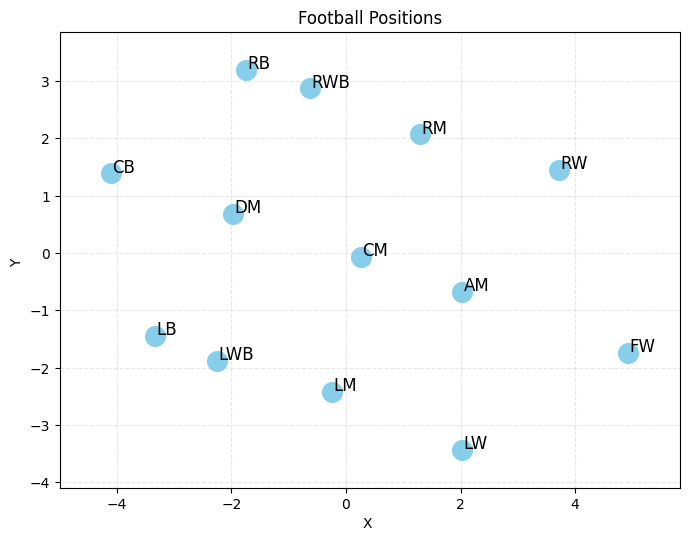

In [30]:
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

distances = {
    ('FW','AM'): 4,
    ('FW','LW'): 2,
    ('FW','RW'): 2,
    ('FW','LM'): 5,
    ('FW','RM'): 5,
    ('FW','LWB'): 7,
    ('FW','RWB'): 7,
    ('FW','LB'): 8,
    ('FW','RB'): 8,
    ('FW','CM'): 7,
    ('FW','DM'): 8,
    ('FW','CB'): 9,

    ('AM','LW'): 2,
    ('AM','RW'): 2,
    ('AM','LM'): 2,
    ('AM','RM'): 2,
    ('AM','LWB'): 5,
    ('AM','RWB'): 5,
    ('AM','LB'): 6,
    ('AM','RB'): 6,
    ('AM','CM'): 1,
    ('AM','DM'): 4,
    ('AM','CB'): 7,

    ('CM','LW'): 4,
    ('CM','RW'): 4,
    ('CM','LM'): 2,
    ('CM','RM'): 2,
    ('CM','LWB'): 4,
    ('CM','RWB'): 4,
    ('CM','LB'): 4,
    ('CM','RB'): 4,
    ('CM','DM'): 1,
    ('CM','CB'): 6,

    ('DM','LW'): 6,
    ('DM','RW'): 6,
    ('DM','LM'): 4,
    ('DM','RM'): 4,
    ('DM','LWB'): 2,
    ('DM','RWB'): 2,
    ('DM','LB'): 3,
    ('DM','RB'): 3,
    ('DM','CB'): 2,

    ('CB','LW'): 7,
    ('CB','RW'): 7,
    ('CB','LM'): 6,
    ('CB','RM'): 6,
    ('CB','LWB'): 4,
    ('CB','RWB'): 4,
    ('CB','LB'): 2,
    ('CB','RB'): 2,

    ('LB','LW'): 5,
    ('LB','RW'): 9,
    ('LB','LM'): 2,
    ('LB','RM'): 6,
    ('LB','LWB'): 1,
    ('LB','RWB'): 5,
    ('LB','RB'): 4,

    ('RB','LW'): 9,
    ('RB','RW'): 5,
    ('RB','LM'): 6,
    ('RB','RM'): 2,
    ('RB','LWB'): 5,
    ('RB','RWB'): 1,

    ('RWB','LW'): 8,
    ('RWB','RW'): 4,
    ('RWB','LM'): 5,
    ('RWB','RM'): 1,
    ('RWB','LWB'): 4,

    ('LWB','LW'): 4,
    ('LWB','RW'): 8,
    ('LWB','LM'): 1,
    ('LWB','RM'): 5,

    ('LM','LW'): 1,
    ('LM','RW'): 7,
    ('LM','RM'): 4,

    ('RM','LW'): 7,
    ('RM','RW'): 1,

    ('RW','LW'): 4
}

def positions_to_coords(dist_dict, n_dim=2, random_state=42):
    # 1. 获取所有位置
    positions = sorted({p for pair in dist_dict.keys() for p in pair})
    n_pos = len(positions)
    pos_index = {p:i for i,p in enumerate(positions)}
    
    # 2. 构建完整距离矩阵（未知距离用较大值或平均值）
    dist_matrix = np.zeros((n_pos,n_pos))
    for i in range(n_pos):
        for j in range(n_pos):
            if i == j:
                dist_matrix[i,j] = 0
            else:
                key1 = (positions[i], positions[j])
                key2 = (positions[j], positions[i])
                if key1 in dist_dict:
                    dist_matrix[i,j] = dist_dict[key1]
                elif key2 in dist_dict:
                    dist_matrix[i,j] = dist_dict[key2]
                else:
                    dist_matrix[i,j] = 1.0 

    mds = MDS(n_components=n_dim, dissimilarity='precomputed', random_state=random_state)
    coords = mds.fit_transform(dist_matrix)
    
    # 4. 输出字典
    pos_coords = {p: coords[pos_index[p]] for p in positions}
    return pos_coords

coords = positions_to_coords(distances, n_dim=2)
for k,v in coords.items():
    print(k, v)
# 提取所有 x, y
xs = [x for x, y in coords.values()]
ys = [y for x, y in coords.values()]

# 创建图
plt.figure(figsize=(8,6))
plt.title("Football Positions")
plt.xlabel("X ")
plt.ylabel("Y ")

# 画每个位置
for pos, (x, y) in coords.items():
    plt.scatter(x, y, s=200, c='skyblue')
    plt.text(x+0.02, y+0.02, pos, fontsize=12)

# 自动设置坐标范围并加边距
x_margin = (max(xs)-min(xs))*0.1
y_margin = (max(ys)-min(ys))*0.1
plt.xlim(min(xs)-x_margin, max(xs)+x_margin)
plt.ylim(min(ys)-y_margin, max(ys)+y_margin)

plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True, linestyle='--', alpha=0.3)

plt.show()


In [132]:
for i in range(len(feat_sets)//10):
    print(list(feat_sets)[i*10:(i+1)*10])

['Crs', 'Blocks', 'Dis', 'PK', 'Venue', 'Carries', 'Sh', 'Clr', 'OG', 'Att 3rd']
['Dead', 'Stp', 'Def 3rd', 'npxG', 'PrgR', 'Comp', 'PKwon', 'PrgDist', 'Stp%', 'xG']
['SoTA', 'Tkld', 'Pass', 'CrsPA', 'Mis', 'Thr', 'PSxG', 'Cmp', 'TklW', 'Cmp%']
['xAG', 'Won', 'Min', 'Opponent', 'PKsv', 'PrgC', 'Live', 'Sw', '#OPA', 'Tkl%']
['Lost', 'Att', 'FK', 'Out', 'Pos', 'Att (GK)', 'PSxG+/-', 'TotDist', 'Err', 'CK']
['Off', 'Won%', 'CrdR', 'Recov', 'Gls', 'Rec', 'Tkl', 'Mid 3rd', 'Fls', 'Ast']
['Result', 'SoT', 'PKm', 'PKA', '/90', 'In', 'GA', 'Opp', 'PSxG/SoT', 'GCA']
['Def Pen', 'Launch%', 'Succ', 'Save%', 'PKcon', 'AvgLen', 'Start', 'Match Report', 'Tkld%', 'Tkl+Int']
['#OPA/90', 'TB', 'Date', 'Touches', 'Int', 'Squad', '1/3', 'Round', 'CrdY', 'PrgP']
['PPA', 'AvgDist', 'Day', 'xA', 'Str', 'KP', 'CS', 'Saves', 'PKatt', 'SCA']


In [176]:
with open(playerinfo['Manchester City']['Erling Haaland']['defense']) as f:
    data = json.load(f)
    print(data[0].keys(), len(data))

dict_keys(['Date', 'Day', 'Comp', 'Round', 'Venue', 'Result', 'Squad', 'Opponent', 'Start', 'Pos', 'Min', 'Tkl', 'TklW', 'Def 3rd', 'Mid 3rd', 'Att 3rd', 'Att', 'Tkl%', 'Lost', 'Blocks', 'Sh', 'Pass', 'Int', 'Tkl+Int', 'Clr', 'Err', 'Match Report']) 32


In [145]:
playerinfo['Manchester City']['Bernardo Silva']
# iterate over defense, keeper,keeper_adv,misc, passing, passing_types, possession json files and print all available feature
for jf in ['defense','keeper','keeper_adv','misc','passing','passing_types','possession']:
    with open(playerinfo['Manchester City']['Bernardo Silva'][jf]) as f:
        data = json.load(f)
        s1 = set(data[0].keys())
        s1.difference_update(set(['Date', 'Day', 'Comp', 'Round', 'Venue', 'Result', 'Squad', 'Opponent', 'Start', 'Pos', 'Match Report','Min']))
        print(jf, len(s1), s1)

defense 15 {'Blocks', 'Err', 'Tkl+Int', 'Sh', 'Clr', 'Tkl', 'Int', 'TklW', 'Att 3rd', 'Def 3rd', 'Mid 3rd', 'Tkl%', 'Lost', 'Att', 'Pass'}
keeper 22 {'Thr', 'PSxG', 'Cmp', 'Stp', 'Cmp%', 'PKm', 'AvgDist', 'PKsv', 'PKA', 'GA', 'CS', 'Opp', 'Stp%', '#OPA', 'Saves', 'PKatt', 'Att', 'Launch%', 'SoTA', 'Save%', 'Att (GK)', 'AvgLen'}
keeper_adv 22 {'CK', 'Thr', '#OPA/90', 'OG', 'PSxG', 'Cmp', 'Stp', 'Cmp%', 'AvgDist', 'PKA', '/90', 'GA', 'Opp', 'Stp%', 'PSxG/SoT', '#OPA', 'Att', 'Launch%', 'FK', 'Att (GK)', 'AvgLen', 'PSxG+/-'}
misc 16 {'Crs', 'Won%', 'Off', 'CrdR', 'Recov', 'OG', 'Int', 'TklW', 'Fls', 'CrdY', 'Won', 'PKwon', 'Lost', 'Fld', '2CrdY', 'PKcon'}
passing 13 {'CrsPA', 'Cmp', '1/3', 'Cmp%', 'xAG', 'Ast', 'PPA', 'xA', 'PrgP', 'KP', 'PrgDist', 'Att', 'TotDist'}
passing_types 15 {'Crs', 'Blocks', 'CK', 'Off', 'TB', 'Cmp', 'Dead', 'Str', 'In', 'Live', 'Sw', 'Att', 'FK', 'Out', 'TI'}
possession 22 {'Dis', 'Mis', 'Tkld%', 'Carries', 'Rec', 'Touches', 'Att 3rd', '1/3', 'Def 3rd', 'Mid 3rd

In [104]:
# for each player, aggregate the stats above across all matches

for team, players in playerinfo.items():
    for player, info in players.items():
        for jf in ['defense','keeper','keeper_adv','misc','passing','passing_types','possession', 'summary']:
            if jf not in info:
                continue
            with open(info[jf]) as f:
                data = json.load(f)
            # aggregate each feature across all matches (sum)
            agg_stats = defaultdict(float)
            m = 0
            for match in data:
                m+=1
                for key, value in match.items():
                    if key in ['Date', 'Day', 'Comp', 'Round', 'Venue', 'Result', 'Squad', 'Opponent', 'Start', 'Pos', 'Match Report']:
                        continue
                    val = safe_float(value)
                    if val is not None:
                        agg_stats[key] += val
            agg_stats['matches_played'] = m
            playerinfo[team][player][f'{jf}_agg'] = dict(agg_stats)

In [105]:
# save player info json

with open('playerinfo_processed_2526.json', 'w') as f:
    json.dump(playerinfo, f, indent=4)

In [108]:
playerinfo['Leeds United']['Noah Okafor']

{'defense': '../../../MusicRecMix/tracks/tracksharepoint/National University of Singapore/Sandesh Sreepathy Upadhyaya - Football Dataset/2526_FINAL/Leeds\xa0United/Noah Okafor/defense.json',
 'info': '../../../MusicRecMix/tracks/tracksharepoint/National University of Singapore/Sandesh Sreepathy Upadhyaya - Football Dataset/2526_FINAL/Leeds\xa0United/Noah Okafor/info.json',
 'keeper': '../../../MusicRecMix/tracks/tracksharepoint/National University of Singapore/Sandesh Sreepathy Upadhyaya - Football Dataset/2526_FINAL/Leeds\xa0United/Noah Okafor/keeper.json',
 'keeper_adv': '../../../MusicRecMix/tracks/tracksharepoint/National University of Singapore/Sandesh Sreepathy Upadhyaya - Football Dataset/2526_FINAL/Leeds\xa0United/Noah Okafor/keeper_adv.json',
 'misc': '../../../MusicRecMix/tracks/tracksharepoint/National University of Singapore/Sandesh Sreepathy Upadhyaya - Football Dataset/2526_FINAL/Leeds\xa0United/Noah Okafor/misc.json',
 'passing': '../../../MusicRecMix/tracks/tracksharepo

In [109]:
# make a summary df

# create a df for summary features for all players
summary_features = []
for team, players in playerinfo.items():
    for player, info in players.items():
        summary_agg = info.get('summary_agg', {})
        if not summary_agg:
            continue
        row = {'team': team, 'player': player}
        row.update(summary_agg)
        summary_features.append(row)

summary_df = pd.DataFrame(summary_features)
summary_df.head()

,team,player,matches_played,Min,Gls,Ast,PK,PKatt,Sh,SoT,...,xAG,SCA,GCA,Cmp,Att,Cmp%,PrgP,Carries,PrgC,Succ
0,Arsenal,Andre Annous,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Arsenal,Ben White,6,70.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,2.0,0.0,21.0,1.0,77.8,4.0,13.0,1.0,1.0
2,Arsenal,Bukayo Saka,6,436.0,2.0,0.0,1.0,1.0,10.0,3.0,...,1.4,25.0,0.0,133.0,30.0,436.5,11.0,158.0,25.0,15.0
3,Arsenal,Christian Nørgaard,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,100.0,0.0,1.0,0.0,0.0
4,Arsenal,Cristhian Mosquera,8,249.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,157.0,1.0,463.0,5.0,131.0,2.0,0.0


In [110]:
summary_df.dropna(inplace=True)

In [111]:
# divide all num features by matches played to get per match stats
num_features = [col for col in summary_df.columns if col not in ['team', 'player']]
for col in num_features:
    summary_df[col] = summary_df[col] / summary_df['matches_played'] 

In [42]:
summary_df.columns

Index(['team', 'player', 'matches_played', 'Min', 'Gls', 'Ast', 'PK', 'PKatt',
       'Sh', 'SoT', 'CrdY', 'CrdR', 'Touches', 'Tkl', 'Int', 'Blocks', 'xG',
       'npxG', 'xAG', 'SCA', 'GCA', 'Cmp', 'Att', 'Cmp%', 'PrgP', 'Carries',
       'PrgC', 'Succ'],
      dtype='object')

In [45]:
sum_Feats=['Min', 'Gls',
       'Sh', 'SoT','Touches', 'Tkl', 'Int', 'Blocks','SCA', 'GCA', 'Cmp', 'Cmp%', 'PrgP', 'Carries','PrgC', 'Succ']

In [76]:
import pickle
with open('test_set_2526.pkl', 'rb') as f:
    test_set = pickle.load(f)

In [77]:
len(test_set)

79

In [112]:
ydf=None
xdf=None
for match_id, match_info in test_set.items():
    xdf_match = None
    for team_key in ['team1_players', 'team2_players']:
        team_name = match_info['team1'] if team_key == 'team1_players' else match_info['team2']
        team_feats=None
        for player_info in match_info[team_key]:
            player_name = player_info['player_name']
            if team_name in playerinfo and player_name in playerinfo[team_name]:
                pos_weights = playerinfo[team_name][player_name].get('position_weights', {})
            else:
                pos_weights = {}

            # player PCA features
            sum_sum = summary_df[(summary_df['team'] == team_name) & (summary_df['player'] == player_name)]
            if sum_sum.empty:
                continue
            sumfeats = sum_sum[sum_Feats].iloc[0].to_dict()
            if team_feats is None:
                team_feats = {}
            team_feats[player_name] = {
                'position_weights': pos_weights,
                'pca_features': sumfeats
            }
        if xdf_match is None:
            xdf_match = {}
        xdf_match[team_key] = team_feats
    if xdf is None:
        xdf = {}

    xdf[match_id] = xdf_match
    
    match_result = {
        'match_id': match_id,
        'team1': match_info['team1'],
        'team2': match_info['team2'],
        # 'formation_team1': match_info['formation_team1'],
        # 'formation_team2': match_info['formation_team2'],
        'result_team1': match_info['result'], # convert to 1 if Win, 0 if Draw, -1 if Lose
        'scoreline': match_info['scoreline']
    }
    match_result_df = pd.DataFrame([match_result])
    if ydf is None:
        ydf = match_result_df
    else:
        ydf = pd.concat([ydf, match_result_df], ignore_index=True)


In [113]:
# create a dataframe with just PCA features for each team in each match in xdf
xtrain = None
for match_id, match_info in test_set.items():
    for team_key in ['team1_players', 'team2_players']:
        team_name = match_info['team1'] if team_key == 'team1_players' else match_info['team2']
        for player_info in match_info[team_key]:
            player_name = player_info['player_name']

            # player PCA features
            sum_sum = summary_df[(summary_df['team'] == team_name) & (summary_df['player'] == player_name)]
            if sum_sum.empty:
                continue
            sumfeats = sum_sum[sum_Feats]
            sumfeats['player_name'] = player_name
            sumfeats['team_name'] = team_name
            sumfeats['match_id'] = match_id
            if xtrain is None:
                xtrain = sumfeats
            else:
                xtrain = pd.concat([xtrain, sumfeats], ignore_index=True)


/tmp/ipykernel_159029/583154991.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sumfeats['player_name'] = player_name
/tmp/ipykernel_159029/583154991.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sumfeats['team_name'] = team_name
/tmp/ipykernel_159029/583154991.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

In [114]:
ydf.head()

,match_id,team1,team2,result_team1,scoreline
0,Arsenal_Liverpool_3_20250831_A,Arsenal,Liverpool,L,0–1
1,Arsenal_Manchester Utd_1_20250817_A,Arsenal,Manchester Utd,W,1–0
2,Arsenal_Nott'ham Forest_4_20250913_H,Arsenal,Nott'ham Forest,W,3–0
3,Arsenal_Manchester City_5_20250921_H,Arsenal,Manchester City,D,1–1
4,Arsenal_Newcastle Utd_6_20250928_A,Arsenal,Newcastle Utd,W,2–1


In [115]:
xtrain.head()

,Min,Gls,Sh,SoT,Touches,Tkl,Int,Blocks,SCA,GCA,Cmp,Cmp%,PrgP,Carries,PrgC,Succ,player_name,team_name,match_id
0,249.0,0.0,0.0,0.0,199.0,8.0,5.0,3.0,1.0,0.0,157.0,463.0,5.0,131.0,2.0,0.0,Cristhian Mosquera,Arsenal,Arsenal_Liverpool_3_20250831_A
1,720.0,0.0,0.0,0.0,295.0,0.0,0.0,0.0,3.0,0.0,205.0,584.2,3.0,174.0,0.0,0.0,David Raya,Arsenal,Arsenal_Liverpool_3_20250831_A
2,633.0,1.0,7.0,1.0,565.0,6.0,3.0,6.0,22.0,3.0,443.0,686.9,54.0,338.0,22.0,6.0,Declan Rice,Arsenal,Arsenal_Liverpool_3_20250831_A
3,456.0,0.0,18.0,6.0,237.0,4.0,1.0,2.0,17.0,3.0,147.0,582.1,23.0,140.0,10.0,9.0,Eberechi Eze,Arsenal,Arsenal_Liverpool_3_20250831_A
4,720.0,1.0,7.0,1.0,583.0,10.0,8.0,12.0,8.0,1.0,438.0,707.0,32.0,339.0,6.0,1.0,Gabriel Magalhães,Arsenal,Arsenal_Liverpool_3_20250831_A


In [116]:
ydf['home_match'] = ydf['match_id'].apply(lambda x: 1 if x.endswith('_H') else 0)

In [117]:
awaymatches = ydf[ydf.home_match == 0.0]
homematches = ydf[ydf.home_match == 1.0]

In [118]:
# flatten xtrain to have one row per match with team1 and team2 pca features
xtrain.head()

,Min,Gls,Sh,SoT,Touches,Tkl,Int,Blocks,SCA,GCA,Cmp,Cmp%,PrgP,Carries,PrgC,Succ,player_name,team_name,match_id
0,249.0,0.0,0.0,0.0,199.0,8.0,5.0,3.0,1.0,0.0,157.0,463.0,5.0,131.0,2.0,0.0,Cristhian Mosquera,Arsenal,Arsenal_Liverpool_3_20250831_A
1,720.0,0.0,0.0,0.0,295.0,0.0,0.0,0.0,3.0,0.0,205.0,584.2,3.0,174.0,0.0,0.0,David Raya,Arsenal,Arsenal_Liverpool_3_20250831_A
2,633.0,1.0,7.0,1.0,565.0,6.0,3.0,6.0,22.0,3.0,443.0,686.9,54.0,338.0,22.0,6.0,Declan Rice,Arsenal,Arsenal_Liverpool_3_20250831_A
3,456.0,0.0,18.0,6.0,237.0,4.0,1.0,2.0,17.0,3.0,147.0,582.1,23.0,140.0,10.0,9.0,Eberechi Eze,Arsenal,Arsenal_Liverpool_3_20250831_A
4,720.0,1.0,7.0,1.0,583.0,10.0,8.0,12.0,8.0,1.0,438.0,707.0,32.0,339.0,6.0,1.0,Gabriel Magalhães,Arsenal,Arsenal_Liverpool_3_20250831_A


In [119]:
# since the order of players in team1_players and team2_players may vary, wee need formation info to align players

In [120]:
teams2526=xtrain.team_name.unique().tolist()

In [121]:
test_set.keys()

dict_keys(['Arsenal_Liverpool_3_20250831_A', 'Arsenal_Manchester Utd_1_20250817_A', "Arsenal_Nott'ham Forest_4_20250913_H", 'Arsenal_Manchester City_5_20250921_H', 'Arsenal_Newcastle Utd_6_20250928_A', 'Arsenal_West Ham_7_20251004_H', 'Arsenal_Fulham_8_20251018_A', 'Arsenal_Leeds United_2_20250823_H', 'Chelsea_Crystal Palace_1_20250817_H', 'Aston Villa_Newcastle Utd_1_20250816_H', 'Aston Villa_Brentford_2_20250823_A', 'Aston Villa_Burnley_7_20251005_H', 'Aston Villa_Tottenham_8_20251019_A', 'Aston Villa_Sunderland_5_20250921_A', 'Aston Villa_Fulham_6_20250928_H', 'Aston Villa_Crystal Palace_3_20250831_H', 'Aston Villa_Everton_4_20250913_A', 'Bournemouth_Liverpool_1_20250815_A', 'Liverpool_Newcastle Utd_2_20250825_A', 'Bournemouth_Wolves_2_20250823_H', 'Bournemouth_Tottenham_3_20250830_A', 'Bournemouth_Crystal Palace_8_20251018_A', 'Bournemouth_Brighton_4_20250913_H', 'Bournemouth_Newcastle Utd_5_20250921_H', 'Bournemouth_Leeds United_6_20250927_A', 'Bournemouth_Fulham_7_20251003_H', "B

In [122]:
# import partial function
from functools import partial
def get_idrow(row, curr):
    teams = [row['Opponent'],curr]
    teams= sorted(teams)
    dates = row['Date']
    if type(dates) == str:
        pass
    else:
        dates = str(dates.date())
    v = row['Venue']
    if teams[0]==curr and v=='Home':
        suffix = f'_{row["Round"].split(" ")[1]}_{dates.replace("-","")}_H'
    elif teams[0]==curr and v=='Away':
        suffix = f'_{row["Round"].split(" ")[1]}_{dates.replace("-","")}_A'
    elif teams[1]==curr and v=='Home':
        suffix = f'_{row["Round"].split(" ")[1]}_{dates.replace("-","")}_A'
    else:
        suffix = f'_{row["Round"].split(" ")[1]}_{dates.replace("-","")}_H'

    return "_".join(teams)+suffix

In [123]:
all_matches=None
for team in list(teaminfo.keys()):
    print(team)
    matchinfodf = pd.read_csv(glob(f"{teaminfo[team]['path']}/match*csv")[0])
    matchinfodf = matchinfodf[matchinfodf['Comp']=='Premier League']
    func = partial(get_idrow, curr=team)
    matchinfodf['match_id'] = matchinfodf.apply(func, axis=1)
    matchinfodf['Squad']=team
    if all_matches is None:
        all_matches = matchinfodf
    else:
        all_matches = pd.concat([all_matches, matchinfodf], ignore_index=True)

Arsenal
Aston Villa
Bournemouth
Brentford
Brighton
Burnley
Chelsea
Crystal Palace
Everton
Fulham
Leeds United
Liverpool
Manchester City
Manchester Utd
Newcastle Utd
Nott'ham Forest
Sunderland
Tottenham
West Ham
Wolves


In [124]:
all_matches = all_matches[all_matches['Venue']=='Home']

In [125]:
def getformationinfo(row):
    team1f=None
    team2f= None # team1, team2
    match_id = row['match_id']
    match_info = all_matches[all_matches['match_id'] == match_id]
    if not match_info.empty:
        if row['team1'] == match_info['Squad'].values[0]:
            team1f = match_info['Formation'].values[0]
            team2f = match_info['Opp Formation'].values[0]
        elif row['team2'] == match_info['Squad'].values[0]:
            team2f = match_info['Formation'].values[0]
            team1f = match_info['Opp Formation'].values[0]
    return team1f, team2f

In [126]:
ydf['team1_formation'], ydf['team2_formation'] = zip(*ydf.apply(lambda row: getformationinfo(row), axis=1))

In [127]:
ydf

,match_id,team1,team2,result_team1,scoreline,home_match,team1_formation,team2_formation
0,Arsenal_Liverpool_3_20250831_A,Arsenal,Liverpool,L,0–1,0,4-3-3,4-2-3-1
1,Arsenal_Manchester Utd_1_20250817_A,Arsenal,Manchester Utd,W,1–0,0,4-3-3,3-4-3
2,Arsenal_Nott'ham Forest_4_20250913_H,Arsenal,Nott'ham Forest,W,3–0,1,4-3-3,4-2-3-1
3,Arsenal_Manchester City_5_20250921_H,Arsenal,Manchester City,D,1–1,1,4-3-3,4-1-4-1
4,Arsenal_Newcastle Utd_6_20250928_A,Arsenal,Newcastle Utd,W,2–1,0,4-2-3-1,4-3-3
...,...,...,...,...,...,...,...,...
74,Nott'ham Forest_West Ham_3_20250831_H,Nott'ham Forest,West Ham,L,0–3,1,4-2-3-1,4-2-3-1
75,Nott'ham Forest_Sunderland_6_20250927_H,Nott'ham Forest,Sunderland,L,0–1,1,4-2-3-1,4-2-3-1
76,Sunderland_Wolves_8_20251018_H,Sunderland,Wolves,W,2–0,1,NaN,NaN
77,Tottenham_West Ham_4_20250913_A,Tottenham,West Ham,W,3–0,0,4-3-3,4-2-3-1


In [128]:
xtrain.drop_duplicates(inplace=True)

In [129]:
xtrain.shape

(2411, 19)

In [130]:
# getting player positions for each match in xtrain
new_test = []
for index, row in xtrain.iterrows():
    match_id = row['match_id']
    team_name = row['team_name']
    player = row['player_name']
    summdf = pd.read_json(playerinfo[team_name][player]['summary'])
    infos = match_id.split('_')
    if infos[0] == team_name:
        oppteam = infos[1]
        matchday = infos[2]
    else:
        oppteam = infos[0]
        matchday = infos[2]
    match_info = summdf[(summdf['Round'] == f'Matchweek {int(matchday)}') & (summdf['Opponent'] == oppteam)]
    row['Pos'] = match_info['Pos'].values[0] if not match_info.empty else None
    row['Minutes'] = match_info['Min'].values[0] if not match_info.empty else None
    row['Starts'] = match_info['Start'].values[0] if not match_info.empty else None
    # convert start Y/N to 1/0
    if row['Starts'] == 'Y':
        row['Starts'] = 1
    elif row['Starts'] == 'N':
        ydf['Starts'] = 0
    new_test.append(row)

In [131]:
xtest = pd.DataFrame(new_test)

In [132]:
xtest['Starts'].replace({'Y*': 1, 'N': 0}, inplace=True)

/tmp/ipykernel_159029/3847216546.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  xtest['Starts'].replace({'Y*': 1, 'N': 0}, inplace=True)
/tmp/ipykernel_159029/3847216546.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  xtest['Starts'].replace({'Y*': 1, 'N': 0}, inplace=True)


In [133]:
xtest[(xtest['match_id']=='Leeds United_Tottenham_7_20251004_H')& (xtest['Starts']==1)&(xtest['team_name']=='Leeds United')]

,Min,Gls,Sh,SoT,Touches,Tkl,Int,Blocks,SCA,GCA,...,PrgP,Carries,PrgC,Succ,player_name,team_name,match_id,Pos,Minutes,Starts
2024,678.0,1.0,14.0,3.0,390.0,14.0,4.0,9.0,25.0,3.0,...,40.0,178.0,12.0,4.0,Anton Stach,Leeds United,Leeds United_Tottenham_7_20251004_H,LM,66,1
2026,462.0,0.0,9.0,4.0,218.0,14.0,5.0,10.0,14.0,3.0,...,15.0,111.0,10.0,5.0,Brenden Aaronson,Leeds United,Leeds United_Tottenham_7_20251004_H,RW,66,1
2027,447.0,1.0,13.0,7.0,135.0,2.0,1.0,3.0,11.0,1.0,...,7.0,69.0,4.0,1.0,Dominic Calvert-Lewin,Leeds United,Leeds United_Tottenham_7_20251004_H,FW,90,1
2028,517.0,0.0,2.0,0.0,433.0,17.0,7.0,3.0,10.0,1.0,...,24.0,212.0,8.0,2.0,Ethan Ampadu,Leeds United,Leeds United_Tottenham_7_20251004_H,"CM,CB",90,1
2029,697.0,0.0,3.0,0.0,476.0,17.0,7.0,10.0,17.0,0.0,...,24.0,239.0,23.0,10.0,Gabriel Gudmundsson,Leeds United,Leeds United_Tottenham_7_20251004_H,LB,78,1
2032,702.0,0.0,7.0,1.0,395.0,21.0,12.0,5.0,9.0,0.0,...,22.0,201.0,22.0,7.0,Jayden Bogle,Leeds United,Leeds United_Tottenham_7_20251004_H,"RB,WB",88,1
2033,720.0,1.0,7.0,3.0,530.0,6.0,9.0,7.0,3.0,0.0,...,38.0,298.0,6.0,1.0,Joe Rodon,Leeds United,Leeds United_Tottenham_7_20251004_H,CB,90,1
2035,450.0,0.0,0.0,0.0,213.0,0.0,0.0,0.0,2.0,0.0,...,1.0,143.0,0.0,0.0,Karl Darlow,Leeds United,Leeds United_Tottenham_7_20251004_H,GK,90,1
2037,351.0,2.0,8.0,3.0,142.0,7.0,3.0,2.0,14.0,2.0,...,11.0,91.0,9.0,12.0,Noah Okafor,Leeds United,Leeds United_Tottenham_7_20251004_H,LW,78,1
2038,720.0,0.0,8.0,1.0,591.0,6.0,2.0,4.0,7.0,1.0,...,23.0,343.0,1.0,0.0,Pascal Struijk,Leeds United,Leeds United_Tottenham_7_20251004_H,CB,90,1


In [134]:
xtest[xtest['Starts']==1]['match_id'].value_counts()

match_id
Tottenham_Wolves_6_20250927_H           22
Arsenal_Liverpool_3_20250831_A          22
Arsenal_Manchester Utd_1_20250817_A     22
Arsenal_Nott'ham Forest_4_20250913_H    22
Arsenal_Manchester City_5_20250921_H    22
                                        ..
Aston Villa_Brentford_2_20250823_A      22
Aston Villa_Burnley_7_20251005_H        22
Aston Villa_Tottenham_8_20251019_A      22
Aston Villa_Sunderland_5_20250921_A     22
Aston Villa_Fulham_6_20250928_H         22
Name: count, Length: 79, dtype: int64

In [164]:
xtrain[(xtrain['Starts']==1)&(xtrain['match_id']=='Fulham_Tottenham_29_20250316_H')&(xtrain['team_name']=='Fulham')]

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,player_name,team_name,match_id,Pos,Minutes,Starts
12342,0.477687,-0.562946,0.031240,0.139547,0.056386,0.121842,-0.083762,Joachim Andersen,Fulham,Fulham_Tottenham_29_20250316_H,CB,90,1
12344,1.014462,0.391746,-0.095407,-0.101722,-0.098819,0.305012,-0.069949,Alex Iwobi,Fulham,Fulham_Tottenham_29_20250316_H,RW,62,1
12345,0.297876,0.177631,-0.132987,0.023307,0.119578,0.226838,0.053727,Andreas Pereira,Fulham,Fulham_Tottenham_29_20250316_H,DM,90,1
12346,0.998438,-0.418541,-0.175343,-0.466101,-0.084616,-0.081016,-0.198093,Antonee Robinson,Fulham,Fulham_Tottenham_29_20250316_H,LB,90,1
12347,-0.073222,-0.362976,-0.289327,0.612278,-0.213283,0.025239,-0.032611,Bernd Leno,Fulham,Fulham_Tottenham_29_20250316_H,GK,90,1
12348,0.478596,-0.476542,0.030957,0.141170,-0.157252,0.018261,-0.042068,Calvin Bassey,Fulham,Fulham_Tottenham_29_20250316_H,CB,90,1
12349,0.478759,0.066458,-0.018256,0.087480,0.019972,0.143416,0.217257,Emile Smith Rowe,Fulham,Fulham_Tottenham_29_20250316_H,AM,71,1
12351,0.434177,0.326868,0.007403,0.257306,0.303773,-0.155431,0.070078,Raúl Jiménez,Fulham,Fulham_Tottenham_29_20250316_H,FW,62,1
12354,0.426210,-0.427645,0.101759,-0.014738,-0.134064,0.073787,0.122400,Sander Berge,Fulham,Fulham_Tottenham_29_20250316_H,DM,90,1
12355,0.012047,-0.233578,0.178394,-0.069430,-0.012444,0.017708,-0.023091,Timothy Castagne,Fulham,Fulham_Tottenham_29_20250316_H,RB,90,1


In [142]:
# save files before training
# save playerinfo, ydf, xtrain
with open('playerinfo_final.json', 'w') as f:
    json.dump(playerinfo, f, indent=4)
ydf.to_csv('matchinfo_test2526.csv', index=False)
xtest.to_csv('player_summ_features_final_2526.csv', index=False)

In [136]:
# get a union of all formations
formations = list(set(pd.Series(pd.concat([ydf['team1_formation'], ydf['team2_formation']]).unique()).values))

In [144]:
xtest[xtest['match_id']=='Arsenal_Liverpool_3_20250831_A']

,Min,Gls,Sh,SoT,Touches,Tkl,Int,Blocks,SCA,GCA,...,PrgP,Carries,PrgC,Succ,player_name,team_name,match_id,Pos,Minutes,Starts
0,249.0,0.0,0.0,0.0,199.0,8.0,5.0,3.0,1.0,0.0,...,5.0,131.0,2.0,0.0,Cristhian Mosquera,Arsenal,Arsenal_Liverpool_3_20250831_A,CB,86,0
1,720.0,0.0,0.0,0.0,295.0,0.0,0.0,0.0,3.0,0.0,...,3.0,174.0,0.0,0.0,David Raya,Arsenal,Arsenal_Liverpool_3_20250831_A,GK,90,1
2,633.0,1.0,7.0,1.0,565.0,6.0,3.0,6.0,22.0,3.0,...,54.0,338.0,22.0,6.0,Declan Rice,Arsenal,Arsenal_Liverpool_3_20250831_A,LM,90,1
3,456.0,0.0,18.0,6.0,237.0,4.0,1.0,2.0,17.0,3.0,...,23.0,140.0,10.0,9.0,Eberechi Eze,Arsenal,Arsenal_Liverpool_3_20250831_A,LW,21,0
4,720.0,1.0,7.0,1.0,583.0,10.0,8.0,12.0,8.0,1.0,...,32.0,339.0,6.0,1.0,Gabriel Magalhães,Arsenal,Arsenal_Liverpool_3_20250831_A,CB,90,1
5,195.0,1.0,5.0,3.0,64.0,3.0,0.0,3.0,3.0,0.0,...,5.0,30.0,6.0,1.0,Gabriel Martinelli,Arsenal,Arsenal_Liverpool_3_20250831_A,LW,69,1
6,612.0,2.0,9.0,5.0,450.0,27.0,6.0,4.0,26.0,3.0,...,47.0,235.0,14.0,5.0,Jurriën Timber,Arsenal,Arsenal_Liverpool_3_20250831_A,RB,90,1
7,203.0,0.0,4.0,1.0,160.0,3.0,1.0,0.0,11.0,3.0,...,26.0,103.0,10.0,3.0,Martin Ødegaard,Arsenal,Arsenal_Liverpool_3_20250831_A,RM,21,0
8,681.0,2.0,6.0,2.0,546.0,15.0,7.0,14.0,15.0,2.0,...,48.0,307.0,7.0,1.0,Martín Zubimendi,Arsenal,Arsenal_Liverpool_3_20250831_A,CM,90,1
9,29.0,0.0,3.0,0.0,19.0,2.0,0.0,1.0,2.0,1.0,...,0.0,13.0,4.0,1.0,Max Dowman,Arsenal,Arsenal_Liverpool_3_20250831_A,RW,2,0


In [147]:
# we need to resolve two data problems
mpos = {4: [0.5,0.25,0.15,0.1], 3:[0.5,0.3,0.2], 2:[0.7,0.3]}
# replacing WB with LWB/RWB based on formation and player affinity as in position_weights
def resolve_WB_positions(row):
    pos = row['Pos']
    if 'WB' not in pos:
        return pos  # no need to resolve
    
    match_id = row['match_id']
    team_name = row['team_name']
    player_name = row['player_name']
    starts = row['Starts']
    if starts != 1:
        return pos  # only resolve for starting players #TODO

    # check if multiple positions assigned to player
    if ',' in pos:
        pos_list = [p.strip() for p in pos.split(',')]
    else:
        pos_list = [pos]

    
    if len(pos_list) == 1:
        la = 0
        ra = 0

        position_weights = playerinfo[team_name][player_name].get('position_weights', {})

        for k,v in position_weights.items():
            if 'L' in k:
                la += v
            elif 'R' in k:
                ra += v
        # normalize to sum to 1
        total = la + ra
        la = la/total if total > 0 else 0
        ra = ra/total if total > 0 else 0
        # check if there is another WB for this match
        wb_matches = xtest[(xtest['match_id']==match_id) & (xtest['team_name']==team_name) & (xtest['Pos']=='WB')&(xtest['Starts']==1)]
        if len(wb_matches) > 1:
            all_players = wb_matches['player_name'].tolist()
            if len(all_players) > 2:
                raise(ValueError("More than two starting WB players found for the same match"))
            other_player = all_players[0] if all_players[1]==player_name else all_players[1]
            other_position_weights = playerinfo[team_name][other_player].get('position_weights', {})
            ola = 0
            ora = 0
            replace_pos = None
            for k,v in other_position_weights.items():
                if 'L' in k:
                    ola += v
                elif 'R' in k:
                    ora += v

            total_o = ola + ora
            ola = ola/total_o if total_o > 0 else 0
            ora = ora/total_o if total_o > 0 else 0
            if ola > la:
                replace_pos = 'RWB'
            elif ora > ra:
                replace_pos = 'LWB'
            
            if replace_pos is None:
                print(la,ra,ola,ora)

            return replace_pos
        
        if la > ra:
            replace_pos= 'LWB'
        else:
            replace_pos= 'RWB'
        return replace_pos
    
    else:
        
        la = 0
        ra = 0
        for idx,p in enumerate(pos_list):
            if p=='WB':
                continue
            v = mpos[len(pos_list)][idx]
            if 'L' in p:
                la += v
            elif 'R' in p:
                ra += v
        if la > ra:
            replace_pos= 'LWB'
        else:
            replace_pos= 'RWB'
        
    return pos.replace('WB', replace_pos)

# cannot resolve

# other problem is players with multiple positions, we will get coordinates of player using weights which can be used in formation to position mapping



In [148]:
xtest.head()

,Min,Gls,Sh,SoT,Touches,Tkl,Int,Blocks,SCA,GCA,...,PrgP,Carries,PrgC,Succ,player_name,team_name,match_id,Pos,Minutes,Starts
0,249.0,0.0,0.0,0.0,199.0,8.0,5.0,3.0,1.0,0.0,...,5.0,131.0,2.0,0.0,Cristhian Mosquera,Arsenal,Arsenal_Liverpool_3_20250831_A,CB,86,0
1,720.0,0.0,0.0,0.0,295.0,0.0,0.0,0.0,3.0,0.0,...,3.0,174.0,0.0,0.0,David Raya,Arsenal,Arsenal_Liverpool_3_20250831_A,GK,90,1
2,633.0,1.0,7.0,1.0,565.0,6.0,3.0,6.0,22.0,3.0,...,54.0,338.0,22.0,6.0,Declan Rice,Arsenal,Arsenal_Liverpool_3_20250831_A,LM,90,1
3,456.0,0.0,18.0,6.0,237.0,4.0,1.0,2.0,17.0,3.0,...,23.0,140.0,10.0,9.0,Eberechi Eze,Arsenal,Arsenal_Liverpool_3_20250831_A,LW,21,0
4,720.0,1.0,7.0,1.0,583.0,10.0,8.0,12.0,8.0,1.0,...,32.0,339.0,6.0,1.0,Gabriel Magalhães,Arsenal,Arsenal_Liverpool_3_20250831_A,CB,90,1


In [149]:
xtest['new_POS'] = xtest.apply(lambda row: resolve_WB_positions(row), axis=1)

In [151]:
def resolve_WB_subs(row):
    pos = row['new_POS']
    if type(pos) != type(""):
        print(pos)
        pos = row['Pos']
        print('replaced',pos)
    if 'WB' not in pos.split(','):
        return pos  # no need to resolve
    
    match_id = row['match_id']
    team_name = row['team_name']
    player_name = row['player_name']
    starts = row['Starts']
    if starts == 1:
        raise(ValueError("This function is only for substitutes"))
        return pos  

    # check if multiple positions assigned to player
    if ',' in pos:
        pos_list = [p.strip() for p in pos.split(',')]
    else:
        pos_list = [pos]

    
    if len(pos_list) == 1:
        la = 0
        ra = 0

        position_weights = playerinfo[team_name][player_name].get('position_weights', {})

        for k,v in position_weights.items():
            if 'L' in k:
                la += v
            elif 'R' in k:
                ra += v
        # normalize to sum to 1
        total = la + ra
        la = la/total if total > 0 else 0
        ra = ra/total if total > 0 else 0

        # other subbed in players for this match
        subbed_players = xtest[(xtest['match_id']==match_id) & (xtest['team_name']==team_name) &(xtest['Starts']==0)&(xtest['Pos']=='WB')]
        if len(subbed_players) > 1:
            all_players = subbed_players['player_name'].tolist()
            if len(all_players) > 2:
                raise(ValueError("More than two starting WB players found for the same match"))
            other_player = all_players[0] if all_players[1]==player_name else all_players[1]
            other_position_weights = playerinfo[team_name][other_player].get('position_weights', {})
            ola = 0
            ora = 0
            replace_pos = None
            for k,v in other_position_weights.items():
                if 'L' in k:
                    ola += v
                elif 'R' in k:
                    ora += v

            total_o = ola + ora
            ola = ola/total_o if total_o > 0 else 0
            ora = ora/total_o if total_o > 0 else 0
            if ola > la:
                replace_pos = 'RWB'
            elif ora > ra:
                replace_pos = 'LWB'
            
            if replace_pos is None:
                # check for subbed out players for this match
                sub_mins = 90-int(row['Minutes'])
                subbed_out_players = xtest[(xtest['match_id']==match_id) & (xtest['team_name']==team_name) &(xtest['Starts']==1)&(xtest['Pos']=='WB')&(xtest['Minutes']==str(sub_mins))]
                if len(subbed_out_players) > 0:
                    all_out_players = subbed_out_players['player_name'].tolist()
                    if len(all_out_players) > 1:
                        raise(ValueError("More than one subbed out WB players found for the same match"))
                    out_player = all_out_players[0]
                    out_player_pos = subbed_out_players['new_POS'].values[0]

                    return out_player_pos
                print(la,ra,ola,ora)        

        if la > ra:
            replace_pos= 'LWB'
        else:
            replace_pos= 'RWB'
        return replace_pos
    
    else:
        
        la = 0
        ra = 0
        for idx,p in enumerate(pos_list):
            if p=='WB':
                continue
            v = mpos[len(pos_list)][idx]
            if 'L' in p:
                la += v
            elif 'R' in p:
                ra += v
        if la > ra:
            replace_pos= 'LWB'
        else:
            replace_pos= 'RWB'
        
    return pos.replace('WB', replace_pos)

In [153]:
xtest['new_POS'] = xtest.apply(lambda row: resolve_WB_subs(row), axis=1)

In [155]:
xtest.drop_duplicates(inplace=True)
xtest.dropna(inplace=True)

In [156]:
# add formations to xtrain
def get_team_formation(row):
    match_id = row['match_id']
    team_name = row['team_name']
    match_info = ydf[ydf['match_id'] == match_id]
    if not match_info.empty:
        if team_name == match_info['team1'].values[0]:
            return match_info['team1_formation'].values[0]
        elif team_name == match_info['team2'].values[0]:
            return match_info['team2_formation'].values[0]
    return None

xtest['formation'] = xtest.apply(lambda row: get_team_formation(row), axis=1)

In [157]:
# get coordinates for each position

mpos = {5: [0.4,0.25,0.15,0.12,0.08 ], 4: [0.5,0.25,0.15,0.1], 3:[0.5,0.3,0.2], 2:[0.7,0.3]}

def get_pos_coords(row):
    pos = row['new_POS']

    if ',' in pos:
        pos_list = [p.strip() for p in pos.split(',')]
    else:
        pos_list = [pos]

    if pos == 'GK':
        return (0.0, 0.0)  # GK no weights 
    
    xcoords = 0.0
    ycoords = 0.0
    if len(pos_list) == 1:
        p = pos_list[0]
        if p not in coords:
            print(p)
            return (0.0, 0.0)
        xcoords = coords[p][0]
        ycoords = coords[p][1]
        return (xcoords, ycoords)
    for idx,p in enumerate(pos_list):
        if p not in coords:
            print(p)
            continue
        v = mpos[len(pos_list)][idx]
        xcoords = coords[p][0] * v + xcoords
        ycoords = coords[p][1] * v + ycoords
    return xcoords, ycoords

In [158]:
xtest['x_coords'] = xtest.apply(lambda row: get_pos_coords(row)[0], axis=1)
xtest['y_coords'] = xtest.apply(lambda row: get_pos_coords(row)[1], axis=1)

In [159]:
# role familiriaty

def get_role_familiarity(row):
    pos = row['new_POS']
    team_name = row['team_name']
    player_name = row['player_name']
    position_weights = playerinfo[team_name][player_name].get('position_weights', {})

    if ',' in pos:
        pos_list = [p.strip() for p in pos.split(',')]
    else:
        pos_list = [pos]

    familiarity = 0.0
    for p in pos_list:
        familiarity += position_weights.get(p, 0.0)
    return familiarity

In [160]:
xtest['familiarity'] = xtest.apply(lambda row: get_role_familiarity(row), axis=1)

In [161]:
formations_positions = {
    "4-5-1": ["GK", "RB", "CB", "CB", "LB", "RM", "CM", "CM", "CM", "LM", "FW"],
    "5-4-1": ["GK", "RB", "CB", "CB", "CB", "LB", "RM", "CM", "CM", "LM", "FW"],
    "3-2-4-1": ["GK", "CB", "CB", "CB", "DM", "DM", "RM", "CM", "CM", "LM", "FW"],
    "4-1-4-1": ["GK", "RB", "CB", "CB", "LB", "DM", "RM", "CM", "CM", "LM", "FW"],
    "4-2-3-1": ["GK", "RB", "CB", "CB", "LB", "DM", "DM", "RM", "AM", "LM", "FW"],
    "3-1-4-2": ["GK", "CB", "CB", "CB", "DM", "RM", "CM", "CM", "LM", "FW", "FW"],
    "5-3-2": ["GK", "RB", "CB", "CB", "CB", "LB", "CM", "CM", "CM", "FW", "FW"],
    "4-3-1-2": ["GK", "RB", "CB", "CB", "LB", "CM", "CM", "CM", "AM", "FW", "FW"],
    "4-4-1-1": ["GK", "RB", "CB", "CB", "LB", "RM", "CM", "CM", "LM", "AM", "FW"],
    "4-1-2-1-2": ["GK", "RB", "CB", "CB", "LB", "DM", "CM", "CM", "AM", "FW", "FW"],
    "3-5-2": ["GK", "CB", "CB", "CB", "RWB", "CM", "CM", "CM", "LWB", "FW", "FW"],
    "4-3-3": ["GK", "RB", "CB", "CB", "LB", "CM", "CM", "CM", "RW", "FW", "LW"],
    "4-2-2-2": ["GK", "RB", "CB", "CB", "LB", "DM", "DM", "RM", "LM", "FW", "FW"],
    "4-4-2": ["GK", "RB", "CB", "CB", "LB", "RM", "CM", "CM", "LM", "FW", "FW"],
    "3-4-3": ["GK", "CB", "CB", "CB", "RM", "CM", "CM", "LM", "RW", "FW", "LW"],
    "3-4-1-2": ["GK", "CB", "CB", "CB", "RM", "CM", "CM", "LM", "AM", "FW", "FW"]
}

In [163]:
sum_Feats

['Min',
 'Gls',
 'Sh',
 'SoT',
 'Touches',
 'Tkl',
 'Int',
 'Blocks',
 'SCA',
 'GCA',
 'Cmp',
 'Cmp%',
 'PrgP',
 'Carries',
 'PrgC',
 'Succ']

In [168]:
xtest.to_csv('player_sumfeatures_final_2526.csv', index=False)

In [164]:
xdf = []

# order each player in xtest according to formation positions and append features to xdf for each match and team

for match_id, match_info in xtest.groupby('match_id'):
    for team_name, team_info in match_info.groupby('team_name'):
        formation = team_info['formation'].values[0]
        if formation not in formations_positions:
            print(f"Formation {formation} not found for team {team_name} in match {match_id}")
            continue
        formation_positions = formations_positions[formation]
        team_players = team_info.copy()
        team_players_start = team_players[team_players['Starts']==1]
        if len(team_players_start) < len(formation_positions):
            print(f"Not enough starting players for team {team_name} in match {match_id}")
            continue
        team_players = team_players_start
        for idx, pos in enumerate(formation_positions):
            # find player closest to position pos
            pos_coord = coords.get(pos, None)
            if pos_coord is None:
                if pos == 'GK':
                    # add GK row to xdf
                    gk_player = team_players[team_players['Pos']=='GK']
                    if gk_player.empty:
                        print(f"No GK found for team {team_name} in match {match_id}")
                        continue
                    selected_player = gk_player.iloc[0]
                    row_data = {
                        'match_id': match_id,
                        'team_name': team_name,
                        'position': pos,
                        'player_name': selected_player['player_name'],
                        'Min': selected_player['Min'],
                        'Gls': selected_player['Gls'],
                        'Sh' : selected_player['Sh'],
                        'SoT':selected_player['SoT'],
                        'Touches' :selected_player['Touches'],
                        'Tkl' :selected_player['Tkl'],
                        'Int':selected_player['Int'],
                        'Blocks':selected_player['Blocks'],
                        'SCA':selected_player['SCA'],
                        'GCA':selected_player['GCA'],
                        'Cmp':selected_player['Cmp'],
                        'Cmp%':selected_player['Cmp%'],
                        'PrgP':selected_player['PrgP'],
                        'Carries':selected_player['Carries'],
                        'PrgC':selected_player['PrgC'],
                        'Succ':selected_player['Succ'],
                        'x_coords': selected_player['x_coords'],
                        'y_coords': selected_player['y_coords'],
                        'familiarity': selected_player['familiarity'],
                        'order': idx
                    }
                    xdf.append(row_data)
                    # remove selected player from team_players to avoid duplicate selection
                    team_players = team_players[team_players['player_name'] != selected_player['player_name']]
                continue
            px, py = pos_coord
            team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
            team_players_sorted = team_players.sort_values(by=['dist_to_pos', 'player_name'])
            if team_players_sorted.empty:
                print(f"No players found for team {team_name} in match {match_id}")
                continue
            selected_player = team_players_sorted.iloc[0]
            row_data = {
                'match_id': match_id,
                'team_name': team_name,
                'position': pos,
                'player_name': selected_player['player_name'],
                'Min': selected_player['Min'],
                'Gls': selected_player['Gls'],
                'Sh' : selected_player['Sh'],
                'SoT':selected_player['SoT'],
                'Touches' :selected_player['Touches'],
                'Tkl' :selected_player['Tkl'],
                'Int':selected_player['Int'],
                'Blocks':selected_player['Blocks'],
                'SCA':selected_player['SCA'],
                'GCA':selected_player['GCA'],
                'Cmp':selected_player['Cmp'],
                'Cmp%':selected_player['Cmp%'],
                'PrgP':selected_player['PrgP'],
                'Carries':selected_player['Carries'],
                'PrgC':selected_player['PrgC'],
                'Succ':selected_player['Succ'],
                'x_coords': selected_player['x_coords'],
                'y_coords': selected_player['y_coords'],
                'familiarity': selected_player['familiarity'],
                'order': idx
            }
            xdf.append(row_data)
            # remove selected player from team_players to avoid duplicate selection
            team_players = team_players[team_players['player_name'] != selected_player['player_name']]
        # to get position index, calculate distance of coordinates from position coordinates, sort by distance, name of player

        

Formation nan not found for team Arsenal in match Arsenal_Fulham_8_20251018_A
Formation nan not found for team Fulham in match Arsenal_Fulham_8_20251018_A


/tmp/ipykernel_159029/3031376986.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_159029/3031376986.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_159029/3031376986.py:60: SettingWithCopyWarning: 
A value i

Formation nan not found for team Aston Villa in match Aston Villa_Tottenham_8_20251019_A
Formation nan not found for team Tottenham in match Aston Villa_Tottenham_8_20251019_A
Formation nan not found for team Bournemouth in match Bournemouth_Crystal Palace_8_20251018_A
Formation nan not found for team Crystal Palace in match Bournemouth_Crystal Palace_8_20251018_A


/tmp/ipykernel_159029/3031376986.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_159029/3031376986.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_159029/3031376986.py:60: SettingWithCopyWarning: 
A value i

Formation nan not found for team Brighton in match Brighton_Newcastle Utd_8_20251018_H
Formation nan not found for team Newcastle Utd in match Brighton_Newcastle Utd_8_20251018_H
Formation nan not found for team Burnley in match Burnley_Leeds United_8_20251018_H
Formation nan not found for team Leeds United in match Burnley_Leeds United_8_20251018_H


/tmp/ipykernel_159029/3031376986.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_159029/3031376986.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_159029/3031376986.py:60: SettingWithCopyWarning: 
A value i

Formation nan not found for team Chelsea in match Chelsea_Nott'ham Forest_8_20251018_A
Formation nan not found for team Nott'ham Forest in match Chelsea_Nott'ham Forest_8_20251018_A


/tmp/ipykernel_159029/3031376986.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_159029/3031376986.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_159029/3031376986.py:60: SettingWithCopyWarning: 
A value i

Formation nan not found for team Everton in match Everton_Manchester City_8_20251018_A
Formation nan not found for team Manchester City in match Everton_Manchester City_8_20251018_A


/tmp/ipykernel_159029/3031376986.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_159029/3031376986.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_159029/3031376986.py:60: SettingWithCopyWarning: 
A value i

Formation nan not found for team Liverpool in match Liverpool_Manchester Utd_8_20251019_H
Formation nan not found for team Manchester Utd in match Liverpool_Manchester Utd_8_20251019_H


/tmp/ipykernel_159029/3031376986.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_159029/3031376986.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_159029/3031376986.py:60: SettingWithCopyWarning: 
A value i

Formation nan not found for team Sunderland in match Sunderland_Wolves_8_20251018_H
Formation nan not found for team Wolves in match Sunderland_Wolves_8_20251018_H


/tmp/ipykernel_159029/3031376986.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_159029/3031376986.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_159029/3031376986.py:60: SettingWithCopyWarning: 
A value i

In [ ]:
# we reconcile the above dict with starting player positions in xtrain

In [167]:
xtest.shape

(2411, 27)

In [165]:
xdf = pd.DataFrame(xdf)

In [166]:
xdf

,match_id,team_name,position,player_name,Min,Gls,Sh,SoT,Touches,Tkl,...,Cmp,Cmp%,PrgP,Carries,PrgC,Succ,x_coords,y_coords,familiarity,order
0,Arsenal_Leeds United_2_20250823_H,Arsenal,GK,David Raya,720.0,0.0,0.0,0.0,295.0,0.0,...,205.0,584.2,3.0,174.0,0.0,0.0,0.000000,0.000000,1.000000,0
1,Arsenal_Leeds United_2_20250823_H,Arsenal,RB,Jurriën Timber,612.0,2.0,9.0,5.0,450.0,27.0,...,300.0,630.5,47.0,235.0,14.0,5.0,-1.743600,3.195911,1.000000,1
2,Arsenal_Leeds United_2_20250823_H,Arsenal,CB,Gabriel Magalhães,720.0,1.0,7.0,1.0,583.0,10.0,...,438.0,707.0,32.0,339.0,6.0,1.0,-4.091569,1.390152,1.000000,2
3,Arsenal_Leeds United_2_20250823_H,Arsenal,CB,William Saliba,499.0,0.0,1.0,0.0,524.0,8.0,...,443.0,548.9,23.0,308.0,2.0,2.0,-4.091569,1.390152,0.847199,3
4,Arsenal_Leeds United_2_20250823_H,Arsenal,LB,Riccardo Calafiori,614.0,1.0,16.0,1.0,418.0,12.0,...,272.0,640.1,25.0,196.0,16.0,2.0,-3.333642,-1.450598,1.000000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1535,Tottenham_Wolves_6_20250927_H,Wolves,CM,Marshall Munetsi,609.0,0.0,8.0,3.0,200.0,14.0,...,68.0,441.4,11.0,76.0,5.0,5.0,0.569715,0.573622,0.488636,6
1536,Tottenham_Wolves_6_20250927_H,Wolves,CM,João Gomes,677.0,0.0,5.0,0.0,462.0,23.0,...,311.0,672.9,44.0,226.0,9.0,6.0,-0.095579,-1.713162,0.902067,7
1537,Tottenham_Wolves_6_20250927_H,Wolves,RW,Jhon Arias,435.0,0.0,8.0,2.0,271.0,21.0,...,163.0,660.4,17.0,126.0,8.0,4.0,4.561595,-0.781588,0.651989,8
1538,Tottenham_Wolves_6_20250927_H,Wolves,FW,Jørgen Strand Larsen,452.0,0.0,9.0,3.0,132.0,1.0,...,62.0,393.3,3.0,72.0,2.0,2.0,4.924469,-1.739962,1.000000,9


In [218]:
# add home or away info to xdf
def get_home_away(row):
    match_id = row['match_id']
    team_name = row['team_name']
    match_info = match_id.split('_')
    team1 = match_info[0]
    team2 = match_info[1]
    homeaway = match_info[-1]
    if team_name == team1 and homeaway == 'H':
        return 1
    elif team_name == team2 and homeaway == 'A':
        return 1
    elif team_name == team1 and homeaway == 'A':
        return 0
    elif team_name == team2 and homeaway == 'H':
        return 0
    return None

In [219]:
xdf['home_away'] = xdf.apply(lambda row: get_home_away(row), axis=1)

In [220]:
xdf.head()

,match_id,team_name,position,player_name,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,x_coords,y_coords,familiarity,order,home_away
0,Arsenal_Aston Villa_22_20250118_H,Arsenal,GK,David Raya,-0.098128,-0.362798,-0.289863,0.585192,-0.193722,0.039448,-0.083642,0.000000,0.000000,1.000000,0,1
1,Arsenal_Aston Villa_22_20250118_H,Arsenal,RB,Thomas Partey,0.722865,-0.340313,0.080606,-0.185473,0.036143,0.134918,0.033022,-1.743600,3.195911,0.271139,1,1
2,Arsenal_Aston Villa_22_20250118_H,Arsenal,CB,Gabriel Magalhães,0.580384,-0.440474,-0.008755,0.208118,0.108437,0.167453,0.055151,-4.091569,1.390152,1.000000,2,1
3,Arsenal_Aston Villa_22_20250118_H,Arsenal,CB,Jurriën Timber,0.572107,-0.222628,-0.031553,-0.123510,-0.146805,0.100004,-0.021129,-4.091569,1.390152,0.118910,3,1
4,Arsenal_Aston Villa_22_20250118_H,Arsenal,LB,Myles Lewis-Skelly,-0.114084,-0.060604,0.069326,0.034613,-0.227078,0.082727,0.066310,-3.333642,-1.450598,0.916946,4,1


In [226]:
# flatten xdf based on home teams player order and away teams player order
final_xdf = []
for match_id, match_info in xdf.groupby('match_id'):
    team1_name = match_info[match_info['home_away']==1]['team_name'].values[0]
    team2_name = match_info[match_info['home_away']==0]['team_name'].values[0]
    team1_players = match_info[(match_info['team_name']==team1_name)].sort_values(by='order')
    team2_players = match_info[(match_info['team_name']==team2_name)].sort_values(by='order')
    row_data = {'match_id': match_id, 'team1': team1_name, 'team2': team2_name}
    for idx, player_row in team1_players.iterrows():
        for pca_idx in range(1,8):
            row_data[f'team1_player{player_row["order"]+1}_PCA{pca_idx}'] = player_row[f'PCA{pca_idx}']
        row_data[f'team1_player{player_row["order"]+1}_familiarity'] = player_row['familiarity']
        row_data[f'team1_player{player_row["order"]+1}_xcord'] = player_row['x_coords']
        row_data[f'team1_player{player_row["order"]+1}_ycord'] = player_row['y_coords']
    for idx, player_row in team2_players.iterrows():
        for pca_idx in range(1,8):
            row_data[f'team2_player{player_row["order"]+1}_PCA{pca_idx}'] = player_row[f'PCA{pca_idx}']
        row_data[f'team2_player{player_row["order"]+1}_familiarity'] = player_row['familiarity']
        row_data[f'team2_player{player_row["order"]+1}_xcord'] = player_row['x_coords']
        row_data[f'team2_player{player_row["order"]+1}_ycord'] = player_row['y_coords']
    final_xdf.append(row_data)

In [227]:
final_xdf = pd.DataFrame(final_xdf)

In [229]:
final_xdf.to_csv('final_player_pca_features_2425_formation_ordered.csv', index=False)

In [230]:
# train a linear regression model to predict scoreline using xtrain and ydf for home matches and away matches
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 80-20 train test split

In [63]:
# train a linear regression model to predict scoreline using final_xdf and ydf for home matches and away matches

8360

In [169]:
ydf.head()

,match_id,team1,team2,result_team1,scoreline,home_match,team1_formation,team2_formation,Starts
0,Arsenal_Liverpool_3_20250831_A,Arsenal,Liverpool,L,0–1,0,4-3-3,4-2-3-1,0
1,Arsenal_Manchester Utd_1_20250817_A,Arsenal,Manchester Utd,W,1–0,0,4-3-3,3-4-3,0
2,Arsenal_Nott'ham Forest_4_20250913_H,Arsenal,Nott'ham Forest,W,3–0,1,4-3-3,4-2-3-1,0
3,Arsenal_Manchester City_5_20250921_H,Arsenal,Manchester City,D,1–1,1,4-3-3,4-1-4-1,0
4,Arsenal_Newcastle Utd_6_20250928_A,Arsenal,Newcastle Utd,W,2–1,0,4-2-3-1,4-3-3,0


In [170]:
# add home score and away score to ydf
def get_home_away_score(row):
    scoreline = row['scoreline']
    scores = scoreline.split('-')
    if len(scores) != 2:
        scores = scoreline.split('–')
        if len(scores) != 2:
            return None, None
    
    homeaway = row['match_id'].split('_')[-1]
    if homeaway == 'H':
        home_score = int(scores[0].strip())
        away_score = int(scores[1].strip())
    else:
        away_score = int(scores[0].strip())
        home_score = int(scores[1].strip())

    return home_score, away_score

In [171]:
ydf['home_score'], ydf['away_score'] = zip(*ydf.apply(lambda row: get_home_away_score(row), axis=1))

In [172]:
ydf.head()

,match_id,team1,team2,result_team1,scoreline,home_match,team1_formation,team2_formation,Starts,home_score,away_score
0,Arsenal_Liverpool_3_20250831_A,Arsenal,Liverpool,L,0–1,0,4-3-3,4-2-3-1,0,1,0
1,Arsenal_Manchester Utd_1_20250817_A,Arsenal,Manchester Utd,W,1–0,0,4-3-3,3-4-3,0,0,1
2,Arsenal_Nott'ham Forest_4_20250913_H,Arsenal,Nott'ham Forest,W,3–0,1,4-3-3,4-2-3-1,0,3,0
3,Arsenal_Manchester City_5_20250921_H,Arsenal,Manchester City,D,1–1,1,4-3-3,4-1-4-1,0,1,1
4,Arsenal_Newcastle Utd_6_20250928_A,Arsenal,Newcastle Utd,W,2–1,0,4-2-3-1,4-3-3,0,1,2


In [173]:
ydf.to_csv('ytest_2526.csv')